# HW05: Practice with algorithm selection, assessment, hyperparameter tuning, multiclass and one-class classification, and imbalanced data.

Waleed Almousa




##### Hello Students:
 Start by downloading HW05.ipynb from this folder. Then develop it into your solution.
- Write code where you see "... your code here ..." below.
  (You are welcome to use more than one cell.)
- If you have questions, please ask them in class or office hours. Our TA
  and I are very happy to help with the programming (provided you start early
  enough, and provided we are not helping so much that we undermine your learning).
- When you are done, run these Notebook commands:
  - Shift-L (once, so that line numbers are visible)
  - Kernel > Restart and Run All (run all cells from scratch)
  - Esc S (save)
  - File > Download as > HTML
- Turn in:
  - HW03.ipynb to Canvas's HW03.ipynb assignment
  - HW03.html to Canvas's HW03.html assignment
  - As a check, download your files from Canvas to a new 'junk' folder. Try 'Kernel > Restart
  and Run All' on the '.ipynb' file to make sure it works. Glance through the '.html' file.
- Turn in partial solutions to Canvas before the deadline. e.g. Turn in part 1,
  then parts 1 and 2, then your whole solution. That way we can award partial credit
  even if you miss the deadline. We will grade your last submission before the deadline.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import mixture

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, linear_model, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                             accuracy_score, roc_auc_score, RocCurveDisplay)

from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler

## 1. Algorithm selection for multiclass classification by optical recognition of handwritten digits

The [digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) dataset
  has 1797 labeled images of hand-written digits.
  - $X$ = `digits.data` has shape (1797, 64).
    - Each image $\mathbf{x}_i$ is represented as the $i$th row of 64 pixel values in the 2D
      `digits.data` array that corresponds to an 8x8 photo of a handwritten digit.
  - $y$ = `digits.target` has shape (1797,). Each $y_i$ is a number from 0 to 9 indicating
    the handwritten digit that was photographed and stored in $\mathbf{x}_i$.



### 1(a) Load the digits dataset and split it into training, validation, and test sets as I did in the lecture example code [07ensemble.html](https://pages.stat.wisc.edu/~jgillett/451/burkov/07/07ensemble.html).
This step does not need to display any output.

In [2]:
digits = datasets.load_digits()
X=digits.data
y=digits.target
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2,
                                                  random_state=0, stratify=y)

X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,
  random_state=0, stratify=y_tmp)

## 1(b) Use algorithm selection on training and validation data to choose a best classifier.
Loop through these four classifiers and corresponding parameters, doing a grid search
to find the best hyperparameter setting. Use only the training data for the grid search.
- SVM:
  - Try all values of `kernel` in 'linear', 'rbf'.
  - Try all values of `C` in 0.01, 1, 100.
- logistic regression:
  - Use `max_iter=5000` to avoid a nonconvergence warning.
  - Try all values of `C` in 0.01, 1, 100.
- ID3 decision tree:
  - Use `criterion='entropy` to get our ID3 tree.
  - Try all values of `max_depth` in 1, 3, 5, 7.
- kNN:
  - (Use the default Euclidean distance).
  - Try all values of `n_neighbors` in 1, 2, 3, 4.

Hint:
- Make a list of the four classifiers without setting any hyperparameters.
- Make a list of four corresponding parameter dictionaries.
- Loop through 0, 1, 2, 3:
  - Run grid search on the $i$th classifier with the $i$th parameter dictionary on the
    training data. (The grid search does its own cross-validation using the training data.)
  - Use the $i$th classifier with its best hyperparameter settings (just `clf` from
    `clf = GridSearchCV(...)`) to find the accuracy of the model on the validation data, i.e.
    find `clf.score(X_valid, y_valid)`.
- Keep track, as your loop progresses, of:
  - the index $i$ of the best classifier (initialize it to `-1` or some other value)
  - the best accuracy score on validation data (initialize it to `-np.Inf`)
  - the best classifier with its hyperparameter settings, that is the best `clf` from
    `clf = GridSearchCV(...)` (initialize it to `None` or some other value)

I needed about 30 lines of code to do this. It took a minute to run.

In [3]:

models=(svm.SVC(), linear_model.LogisticRegression(max_iter=5000), DecisionTreeClassifier() , KNeighborsClassifier())
params=[{'kernel':('linear', 'rbf'), 'C':[0.01, 1, 100]}, {'C':[0.01, 1, 100]}, {'criterion':['entropy'], 'max_depth':[1, 3, 5, 7]}, {'n_neighbors':[1, 2, 3, 4]}]
best_index=-1
best_acc=-np.Inf
best_clf=None
for i in [0, 1, 2, 3]:
    clf=GridSearchCV(models[i], params[i])
    clf.fit(X_train,y_train)
    accuracy=clf.score(X_valid, y_valid)
    if accuracy>best_acc:
        best_acc=accuracy
        best_clf=clf
        best_index=i
        best_params=clf.best_params_
    print("model:", models[i],"\nAccuracy of model: ", accuracy, "\n")
    
print("best model:", models[best_index], "\nindex:", best_index, "\naccuracy of best model:", best_acc, "\nbest parameters:", best_params)

model: SVC() 
Accuracy of model:  0.9888888888888889 

model: LogisticRegression(max_iter=5000) 
Accuracy of model:  0.9722222222222222 

model: DecisionTreeClassifier() 
Accuracy of model:  0.8555555555555555 

model: KNeighborsClassifier() 
Accuracy of model:  0.9888888888888889 

best model: SVC() 
index: 0 
accuracy of best model: 0.9888888888888889 
best parameters: {'C': 1, 'kernel': 'rbf'}


### 1(c) Use the test data to evaluate your already-fit best classifier and its hyperparameter settings from 1(b).
- Well, there are two tied for 'best'. Please use the first of these two.
- Report the result of calling `.score(X_test, y_test)` on your best classifier/hyperparameters.
- Show a confusion matrix from the true `y_test` values and the corresponding $\hat{y}$ values
  predicted by your best classifier/hyperparameters on `X_test`.
- For each of the wrong predictions (where `y_test` and your $\hat{y}$ values disagree), show:
  - The index $i$ in the test data of that example $\mathbf{x}$
  - The correct label $y_i$
  - Your incorrect prediction $\hat{y}_i$
  - A plot of that image (to see whether the confusion was reasonable)

Score: 0.9777777777777777
Confusion matrix:
[[18  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  1  0  0]
 [ 0  0  0  0 17  0  0  0  1  0]
 [ 0  0  0  0  0 18  0  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0]
 [ 0  0  0  0  0  0  0 18  0  0]
 [ 0  1  0  0  0  0  0  0 16  0]
 [ 0  0  0  0  0  1  0  0  0 17]]

Index in Test Data: 61
Correct Label (y61): 9
Incorrect Prediction (ŷ61): 5


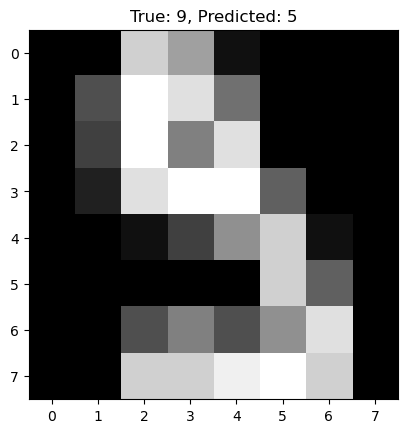


Index in Test Data: 65
Correct Label (y65): 4
Incorrect Prediction (ŷ65): 8


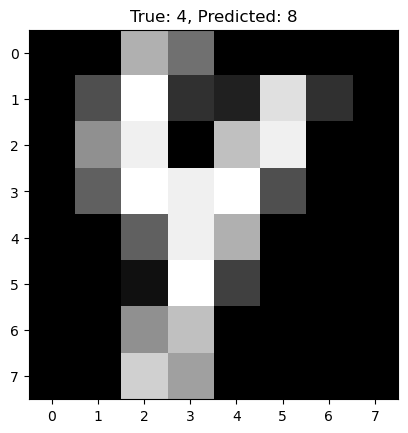


Index in Test Data: 152
Correct Label (y152): 8
Incorrect Prediction (ŷ152): 1


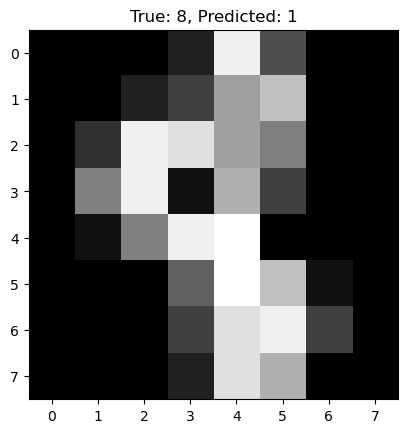


Index in Test Data: 177
Correct Label (y177): 3
Incorrect Prediction (ŷ177): 7


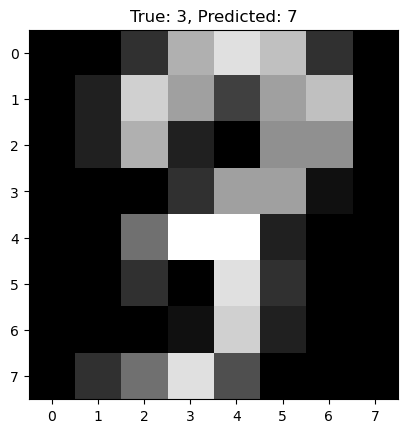

In [4]:
clf=svm.SVC(C=1, kernel="rbf")
clf.fit(X_train, y_train)
score=clf.score(X_test, y_test)
print("Score:", score)
y_pred=clf.predict(X_test)
conf_matrix=confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(conf_matrix)

incorrect_indices = np.where(y_test != y_pred)[0]

for i in incorrect_indices:
    correct_label = y_test[i]
    incorrect_prediction = y_pred[i]

    print(f"\nIndex in Test Data: {i}")
    print(f"Correct Label (y{i}): {correct_label}")
    print(f"Incorrect Prediction (ŷ{i}): {incorrect_prediction}")

    plt.imshow(X_test[i].reshape(8, 8), cmap='gray')
    plt.title(f"True: {correct_label}, Predicted: {incorrect_prediction}")
    plt.show()


## 2. One-class classification (outlier detection)

### 2(a) There is an old gradebook at [http://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt](http://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt).
Use `pd.read_table()` to read it into a DataFrame.

Hint: `pd.read_table()` has many parameters. Check its documentation to find three parameters to:
- Read from the given URL
- Use the separator '\s+', which means 'one or more whitespace characters'
- Skip the first 12 rows, as they are a note to students and not part of the gradebook

In [5]:
grades=pd.read_table('http://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt', sep='\s+', skiprows=12)
grades.head()

,Exam1,Exam2,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,HW6,HW7,HW8,HW9,Percentage,Rank,Percentile,percentageGrade,percentileGrade,Grade
0,121,120,4,4.0,4.0,4.0,4.0,4,4.0,4.0,...,4.0,3.5,3.0,4.0,97.13,391,99.7,A,A,A
1,119,116,4,4.0,4.0,4.0,4.0,4,4.0,4.0,...,4.0,3.5,4.0,3.5,95.22,390,99.5,A,A,A
2,125,109,4,4.0,4.0,4.0,4.0,4,4.0,4.0,...,3.0,4.0,4.0,2.5,94.90,389,99.2,A,A,A
3,117,115,4,4.0,4.0,4.0,4.0,4,4.0,4.0,...,4.0,4.0,3.5,4.0,94.27,387,98.7,A,A,A
4,110,122,4,4.0,4.0,4.0,4.0,4,4.0,4.0,...,4.0,4.0,4.0,4.0,94.27,387,98.7,A,A,A


### 2(b) Use `clf = mixture.GaussianMixture(n_components=1)` to make a one-class Gaussian model to decide which $\mathbf{x}=(\text{Exam1}, \text{Exam2})$ are outliers:

- Set a matrix X to the first two columns, Exam1 and Exam.
- These exams were worth 125 points each. Transform scores to percentages in $[0, 100]$.

  Hint: I tried the MinMaxScaler() first, but it does the wrong thing if there aren't scores
  of 0 and 125 in each column. So, instead, I just multiplied the whole matrix by 100 / 125.
- Fit your classifier to X.
  
  Hint:
  - The reference page for `mixture.GaussianMixture` includes a `fit(X, y=None)` method
    with the comment that y is ignored (as this is an unsupervised learning algorithm--there
    is no $y$) but present for API consistency. So we can fit with just X.
  - I got a warning about "KMeans ... memory leak". You may ignore this
    warning if you see it. I still got satisfactory results.
- Print the center $\mathbf{\mu}$ and covariance matrix $\mathbf{\Sigma}$ from the two-variable
  $N_2(\mathbf{\mu}, \mathbf{\Sigma})$ distribution you estimated.

In [6]:
clf = mixture.GaussianMixture(n_components=1)
X=grades[['Exam1', 'Exam2']] *(100/125)
clf.fit(X)

print("Estimated Mean (Center):", clf.means_)
print("\nEstimated Covariance Matrix:")
print(clf.covariances_)

Estimated Mean (Center): [[82.81329923 71.01176471]]

Estimated Covariance Matrix:
[[[155.51123078  73.02961336]
  [ 73.02961336 180.87014392]]]


C:\Users\walee\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


### 2(c) Here I have given you code to make a contour plot of the negative log likelihood $-\ln f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ for $\mathbf{X} \sim N_2(\mathbf{\mu}, \mathbf{\Sigma})$, provided you have set `clf`.

```
# make contour plot of log-likelihood of samples from clf.score_samples()
margin = 10
x = np.linspace(0 - margin, 100 + margin)
y = np.linspace(0 - margin, 100 + margin)
grid_x, grid_y = np.meshgrid(x, y)
two_column_grid_x_grid_y = np.array([grid_x.ravel(), grid_y.ravel()]).T
negative_log_pdf_values = -clf.score_samples(two_column_grid_x_grid_y)
grid_z = negative_log_pdf_values
grid_z = grid_z.reshape(grid_x.shape)
plt.contour(grid_x, grid_y, grid_z, levels=10) # X, Y, Z
plt.title('(Exam1, Exam2) pairs')
```

Paste my code into your code cell below and add more code:
- Add black $x$- and $y$- axes. Label them Exam1 and Exam2.
- Plot the data points in blue.
- Plot $\mathbf{\mu}=$ `clf.means_` as a big lime dot.
- Overplot (i.e. plot again) in red the 8 outliers determined by a threshold consisting
  of the 0.02 quantile of the pdf values $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$
  for each $\mathbf{x}$ in X.
  
  Hint: `clf.score_samples(X)` gives log likelihood, so `np.exp(clf.score_samples(X))`
  gives the required $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ values.

C:\Users\walee\anaconda3\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


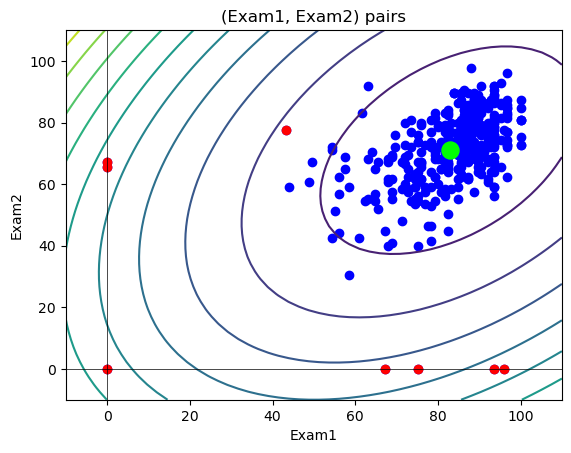

In [7]:
margin = 10
x = np.linspace(0 - margin, 100 + margin)
y = np.linspace(0 - margin, 100 + margin)
grid_x, grid_y = np.meshgrid(x, y)
two_column_grid_x_grid_y = np.array([grid_x.ravel(), grid_y.ravel()]).T
negative_log_pdf_values = -clf.score_samples(two_column_grid_x_grid_y)
grid_z = negative_log_pdf_values
grid_z = grid_z.reshape(grid_x.shape)
plt.contour(grid_x, grid_y, grid_z, levels=10) # X, Y, Z
plt.title('(Exam1, Exam2) pairs')


plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Exam1")
plt.ylabel("Exam2")
plt.scatter(x=X["Exam1"], y=X["Exam2"], color="blue")

plt.scatter(clf.means_[0, 0], clf.means_[0, 1], color='lime', s=150)

pdf_values = np.exp(clf.score_samples(X))
threshold = np.quantile(pdf_values, 0.02)

outliers=X[pdf_values<threshold]
plt.scatter(x=outliers['Exam1'], y=outliers['Exam2'], color='red')
plt.show()

### What characterizes 7 of these 8 outliers? Write your answer in a markdown cell.

7 of the 8 outliers got a zero on at least one exam

### 2(d) Write a little code to report whether, by the 0.02 quantile criterion, $\mathbf{x}=$ (Exam1=50, Exam2=100) is an outlier.

Hint: Compare $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ to your threshold

In [8]:
data_point = pd.DataFrame({'Exam1': [50], 'Exam2': [100]})

pdf_test=np.exp(clf.score_samples(data_point))
is_outlier=pdf_test<threshold
print(is_outlier)
print("The data point (Exam1=50, Exam2=100) is an outlier")

[ True]
The data point (Exam1=50, Exam2=100) is an outlier


## 3. Explore the fact that accuracy can be misleading for imbalanced data.
Here I make a fake imbalanced data set by randomly sampling $y$ from a distribution with $P(y = 0) = 0.980$ and $P(y = 1) = 0.020$.

In [9]:
X, y = make_classification(n_samples=1000, n_features=4, n_classes=2, weights=[0.980, 0.020],
                           n_clusters_per_class=1, flip_y=0.01, random_state=0)
print(f'np.bincount(y)={np.bincount(y)}; we expect about 980 zeros and 20 ones.')
print(f'np.mean(y)={np.mean(y)}; we expect the proportion of ones to be about 0.020.')

np.bincount(y)=[973  27]; we expect about 980 zeros and 20 ones.
np.mean(y)=0.027; we expect the proportion of ones to be about 0.020.


Here I split the data into 50% training and 50% testing data.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0, stratify=y)
print(f'np.bincount(y_train)={np.bincount(y_train)}')
print(f'np.mean(y_train)={np.mean(y_train)}.')
print(f'np.bincount(y_test)={np.bincount(y_test)}.')
print(f'np.mean(y_test)={np.mean(y_test)}.')

np.bincount(y_train)=[486  14]
np.mean(y_train)=0.028.
np.bincount(y_test)=[487  13].
np.mean(y_test)=0.026.


### 3a. Train and assess a gradient boosting model.
- Train on the training data.
- Use 100 trees of maximum depth 1 and learning rate $\alpha = 0.25$.
- Use `random_state=0` (to give us all a chance of getting the same results).
- Display the accuracy, precision, recall, and AUC on the test data. Use 3 decimal places.
  Use a labeled print statement with 3 decimal places so the reader can easily find each metric.
- Make an ROC curve from your classifier and the test data.

Accuracy: 0.982
Precision: 0.7
Recall: 0.538
AUC: 0.769


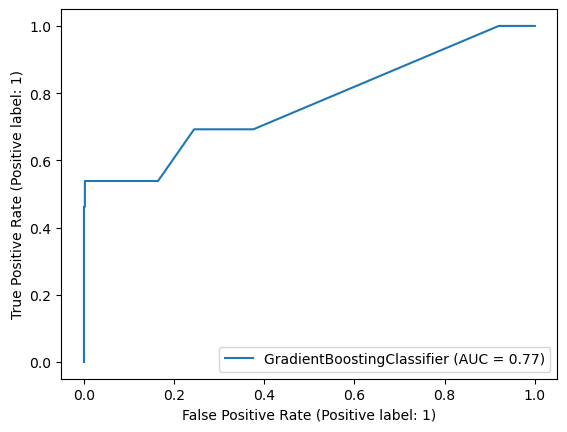

In [11]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.25,
    max_depth=1, random_state=0)
clf.fit(X_train, y_train)
y_hat=clf.predict(X_test)
y_prob=clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_hat)
precision= precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
auc = roc_auc_score(y_test, y_prob)


print(f"Accuracy: {accuracy:.3}")
print(f"Precision: {precision:.3}")
print(f"Recall: {recall:.3}")
print(f"AUC: {auc:.3}")

RocCurveDisplay.from_estimator(clf, X_test, y_test)



Note the high accuracy but lousy precision, recall, and AUC.

Note that since the data have about 98% $y = 0$, we could get about 98% accuracy
by just always predicting $\hat{y} = 0$. High accuracy alone is not necessarily helpful.

### 3b. Now oversample the data to get a balanced data set.
- Use the `RandomOverSampler(random_state=0)` to oversample and get a balanced data set.
- Repeat my `train_test_split()` block from above.
- Repeat your train/assess block from above.

Accuracy: 0.957
Precision: 0.97
Recall: 0.942
AUC: 0.993


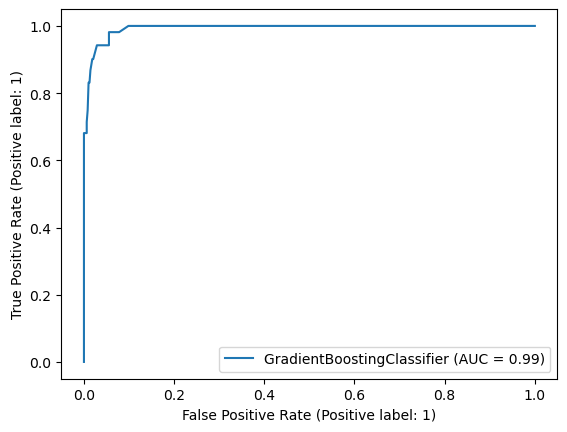

In [12]:
rs=RandomOverSampler(random_state=0)
X_resampled, y_resampled = rs.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.5,
                                                    random_state=0, stratify=y_resampled)


clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.25,
    max_depth=1, random_state=0)
clf.fit(X_train, y_train)
y_hat=clf.predict(X_test)
y_prob=clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_hat)
precision= precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
auc = roc_auc_score(y_test, y_prob)


print(f"Accuracy: {accuracy:.3}")
print(f"Precision: {precision:.3}")
print(f"Recall: {recall:.3}")
print(f"AUC: {auc:.3}")

RocCurveDisplay.from_estimator(clf, X_test, y_test)


Note that we traded a little accuracy for much improved precision, recall, and AUC.

If you do classification in your project and report accuracy, please
also report the proportions of $y = 0$ and $y = 1$ in your test data so that
we get insight into whether your model improves upon always guessing $\hat{y} = 0$
or always guessing $\hat{y} = 1$.